## Autores:
- Camilla Balliana;
- José Arthur de Luna Oliveira;
- Natália Pereira dos Santos;
- Bruno R. Carvalho.

### Importando Bibliotecas


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh  # solver recomendado para matrizes simétricas
import warnings

#### Detalhes das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.13.5 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.30.0
OS Windows 11 10.0.26200 SP0
Matplotlib 3.10.0
Numpy 2.1.3
Scipy 1.15.3
Thu Feb 05 15:52:46 2026 Hora oficial do Brasil

## Poço Finito Equação Transcendental

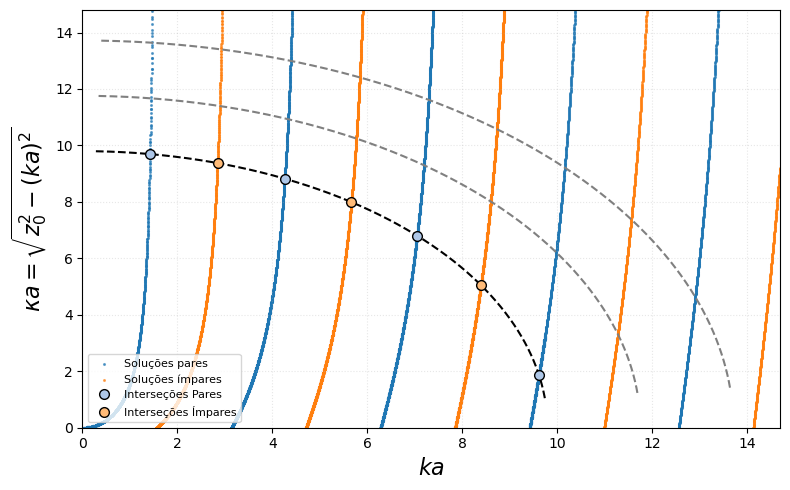

In [3]:
# Parâmetros do sistema (unidades arbitrárias)
a = 2.0       # Semi-largura do poço
V0 = 12.0     # Profundidade do poço
hbar = 1.0    # Constante de Planck reduzida
m = 1.0       # Massa da partícula

# Varredura de energias (restrita a E < V0)
E_varredura = np.linspace(0.01, V0 * 0.99, 10000)

# Constantes k e kappa
k = np.sqrt(2 * m * E_varredura / hbar**2)
kappa = np.sqrt(2 * m * (V0 - E_varredura) / hbar**2)

# Variáveis adimensionais
u = kappa * a
v = k * a

# Constante (raio do círculo)
z0 = a * np.sqrt(2 * m * V0 / hbar**2)
circulo = np.sqrt(z0**2 - v**2)

u_max = z0 * 1.5  # Define o eixo x 50% maior que o raio do círculo
u_ = np.linspace(0.01, u_max, 10000)

# Suprime o aviso causado pelas assíntotas da tangente
np.seterr(divide='ignore', invalid='ignore')
funcao_par_ = u_ * np.tan (u_)
funcao_impar_ = -u_ / np.tan (u_)
funcao_par = v * np.tan(v)
funcao_impar = -v / np.tan(v)
np.seterr(divide='warn', invalid='warn')

# Função para encontrar interseções de forma segura
def encontrar_intersecoes(v, f1, f2, limite_valor=2*z0):
    mask_finite = np.isfinite(f1) & np.isfinite(f2)
    # Remove pontos muito grandes (próximos às assíntotas)
    mask_finite &= np.abs(f1) < limite_valor
    mask_finite &= np.abs(f2) < limite_valor

    idx = []
    for i in range(len(v) - 1):
        if mask_finite[i] and mask_finite[i+1]:
            if (f1[i] - f2[i]) * (f1[i+1] - f2[i+1]) < 0:
                idx.append(i)
    return np.array(idx)

# Identificação das interseções
idx_par = encontrar_intersecoes(v, circulo, funcao_par)
idx_impar = encontrar_intersecoes(v, circulo, funcao_impar)

# Construção gráfica
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Curva de referência (círculo)
axes.plot(v, circulo, '--', color="black", linewidth=1.5)
axes.plot(v * 1.2, circulo * 1.2, '--', color="gray", linewidth=1.5)
axes.plot(v * 1.4, circulo * 1.4, '--', color="gray", linewidth=1.5)

# Funções transcendentes (scatter com transparência)
axes.scatter(u_, funcao_par_, s=1.5, color='#1f77b4', alpha=0.6, label='Soluções pares')
axes.scatter(u_, funcao_impar_, s=1.5, color='#ff7f0e', alpha=0.6, label='Soluções ímpares')

axes.scatter(v, funcao_par, s=1.5, color='#1f77b4', alpha=0.6, label='Soluções pares')
axes.scatter(v, funcao_impar, s=1.5, color='#ff7f0e', alpha=0.6, label='Soluções ímpares')

# Pontos de interseção
axes.plot(v[idx_par], circulo[idx_par], 'o', ms=7, mfc='#aec7e8', mec='black', label='Interseções Pares')
axes.plot(v[idx_impar], circulo[idx_impar], 'o', ms=7, mfc='#ffbb78', mec='black', label='Interseções Ímpares')

# Configurações do gráfico
axes.set_xlim([0.0, u_max])
axes.set_ylim([0.0, z0+5])
axes.set_ylabel(r'$\kappa a = \sqrt{z_0^2 - (ka)^2}$', fontsize=16)
axes.set_xlabel(r'$ka$', fontsize=16)
axes.grid(True, linestyle=':', alpha=0.3)

# Legenda para funções e interseções
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels, unique_handles = [], []
for i, label in enumerate(labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handles[i])
axes.legend(unique_handles, unique_labels, loc='lower left', fontsize=8)

plt.tight_layout()
plt.show()

In [4]:
#Calculando energias vinculadas aos pontos de interseção
E_par = (hbar**2 * v[idx_par]**2) / (2 * m * a**2)
E_impar = (hbar**2 * v[idx_impar]**2) / (2 * m * a**2)
print("Energias pares:", E_par)
print("Energias ímpares:", E_impar)

Energias pares: [ 0.25335934  2.27027403  6.21388239 11.56066507]
Energias ímpares: [1.01192819 4.0129643  8.81011101]


### Recuperando Unidades

In [5]:
# Constantes físicas (SI)
hbar = 1.0545718e-34  # Constante de Planck reduzida (J.s)
m_e = 9.10938356e-31  # Massa do elétron (kg)
q_e = 1.60217663e-19  # Carga elementar (para conversão Joule -> eV)

# Parâmetros do sistema físico
L = 1.0e-9            # Largura do poço quântico (1 nm)
E_num = 0.25          # Autovalor adimensional obtido numericamente

# Cálculo da energia no SI (Joules)
# Relação: E_si = E_num * (hbar^2 / (m * L^2))
fator_conversao = (hbar**2) / (m_e * (L**2))
E_joule = E_num * fator_conversao

# Conversão para milieletrón-volts (meV)
E_mev = (E_joule / q_e) * 1000

print(f"Energia numérica: {E_num}")
print(f"Energia em Joules: {E_joule:.4e} J")
print(f"Energia em meV: {E_mev:.2f} meV")

Energia numérica: 0.25
Energia em Joules: 3.0521e-21 J
Energia em meV: 19.05 meV


## Poço Finito Análise Numérica

In [6]:
# Parâmetros físicos do sistema (adimensionais)
hbar = 1.0
m = 1.0

# Parâmetros da malha espacial
xmin, xmax = -5.0, 5.0
N_pontos = 1002 # N total de pontos, incluindo as bordas
x = np.linspace(xmin, xmax, N_pontos)
dx = x[1] - x[0]

# Parâmetros do potencial
L_poco = 2.0   # largura do poço
V0 = 12.0      # profundidade do poço

# Cria o vetor de potencial apenas para os pontos internos da malha
x_interno = x[1:-1]
V_interno = np.where((x_interno < L_poco) & (x_interno > -L_poco), 0.0, V0)

# Construção do Hamiltoniano (sparse)
dim_H = N_pontos - 2  # dimensão da matriz Hamiltoniana (N-2 pontos internos)

# Operador de energia cinética no formato matricial
energia_cinetica = -(hbar**2) / (2 * m * dx**2)
diagonal_principal = np.full(dim_H, -2.0)
diagonal_secundaria  = np.full(dim_H - 1, 1.0)
T = diags([diagonal_secundaria, diagonal_principal, diagonal_secundaria], offsets=[-1, 0, 1], shape=(dim_H, dim_H))
T = energia_cinetica * T

# Operador de energia potencial (matriz diagonal)
Vmat = diags([V_interno], [0], shape=(dim_H, dim_H))
# Hamiltoniano total
H = T + Vmat

# Número de autovalores a pedir (sempre < dim_H)
k_estados = 6
k_estados = max(1, min(k_estados, dim_H - 2))  # segurança

# Tentativa principal: eigsh (simétrico)
try:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # suprimir warnings numéricos momentâneos
        todos_autovalores, autovetores_interno = eigsh(H, k=k_estados, which='SA')  # 'SA' = smallest algebraic
    todos_autovalores = todos_autovalores.real
    autovetores_interno = autovetores_interno.real
    soluc_usado = "eigsh (ARPACK)"
except Exception as e:
    # fallback robusto: solução densa
    H_densa = H.toarray()
    valores, vetores = np.linalg.eigh(H_densa)
    todos_autovalores = valores[:k_estados].real
    autovetores_interno = vetores[:, :k_estados].real
    soluc_usado = "numpy.linalg.eigh (fallback)"

# Ordenamento consistente dos autovalores e vetores
order = np.argsort(todos_autovalores)
todos_autovalores = todos_autovalores[order]
autovetores_interno = autovetores_interno[:, order]

# Selecionar estados ligados E < V0 (com margem numérica)
tol = 1e-8
bound_idx = np.where(todos_autovalores < V0 - tol)[0]
E_ligado = todos_autovalores[bound_idx]
autovetores_ligado_interno = autovetores_interno[:, bound_idx]

num_ligado = len(E_ligado)

if num_ligado == 0:
    raise RuntimeError("Nenhum estado ligado encontrado. Tente aumentar k_states, V0 ou L_poco.")

# Reconstruir vetores no domínio completo (com bordas 0)
autovetores_completo = np.zeros((N_pontos, num_ligado))
autovetores_completo[1:-1, :] = autovetores_ligado_interno

# Normalização segura usando x
def normalizacao(psi, xvec):
    """Normaliza um vetor de função de onda usando a regra do trapézio"""
    norm = np.sqrt(np.trapz(np.abs(psi)**2, x=xvec))
    if norm == 0:
        return psi
    return psi / norm

for i in range(num_ligado):
    # Normaliza primeiro
    autovetores_completo[:, i] = normalizacao(autovetores_completo[:, i], x)
    
    #Correção de fase para fixar concavidade
    """Encontra o valor absoluto máximo da função de onda"""
    max_amp = np.max(np.abs(autovetores_completo[:, i]))
    
    """Encontra o índice correspondente a este valor máximo"""
    max_idx = np.where(np.abs(autovetores_completo[:, i]) == max_amp)[0][0]
    
    """Se o valor nesse ponto for negativo, inverte a função de onda inteira"""
    if autovetores_completo[max_idx, i] < 0:
        autovetores_completo[:, i] *= -1

C:\Users\olive\AppData\Local\Temp\ipykernel_25988\4007693005.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(np.abs(psi)**2, x=xvec))


### Construção gráfica das funções de onda e densidade de probabilidade

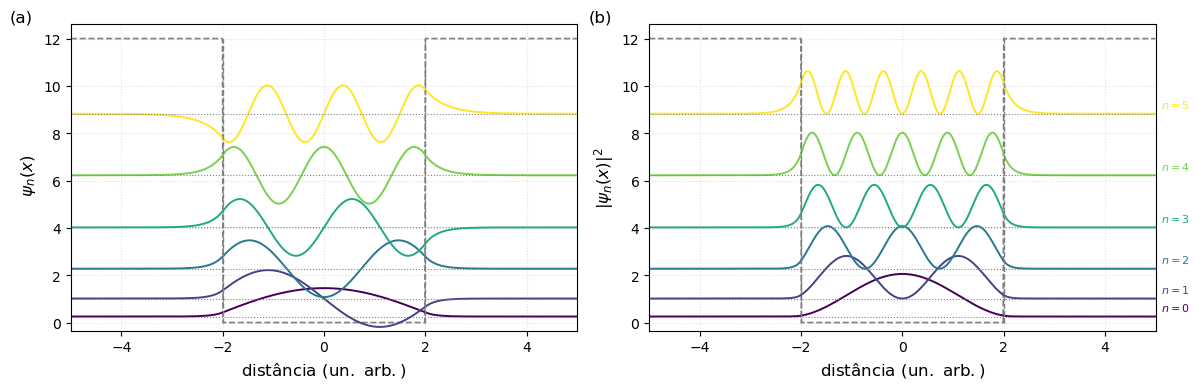

In [7]:
# Preparando para plot
V_plot = np.where((x < L_poco) & (x > -L_poco), 0.0, V0)

# Construção gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Colormap para diferenciar cada estado
cores = plt.cm.viridis(np.linspace(0, 1, len(E_ligado)))

### Painel (a): Funções de onda ### 

# Desenhando o potencial
ax1.plot(x, V_plot, color='tab:gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

for i, E in enumerate(E_ligado):
    """Encontra a amplitude máxima da curva"""
    max_amp = np.max(np.abs(autovetores_completo[:, i]))
    """Define um fator de escala (ajuste se necessário)"""
    fator_escala = 0.1 * V0 / max_amp
    
    ax1.plot(x, E + fator_escala * autovetores_completo[:, i], color=cores[i], linewidth=1.4,
             label=rf"$n={i}$")
    ax1.hlines(E, xmin, xmax, linestyle=':', color='gray', linewidth=0.8)

### Painel (b): Densidades de probabilidade ###

# Desenhando o potencial
ax2.plot(x, V_plot, color='tab:gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

for i, E in enumerate(E_ligado):
    """Encontra a amplitude máxima da curva"""
    max_amp_prob = np.max(np.abs(autovetores_completo[:, i])**2) 
    """Define um fator de escala (ajuste se necessário)"""
    fator_escala_prob = 0.15 * V0 / max_amp_prob
    
    ax2.plot(x, E + fator_escala_prob * np.abs(autovetores_completo[:, i])**2, color=cores[i], linewidth=1.4,
             label=rf"$n={i}$")
    ax2.hlines(E, xmin, xmax, linestyle=':', color='gray', linewidth=0.8)
    
    ax2.text(xmax + 0.1, E + 0.02 * V0, rf"$n={i}$", fontsize=8, color=cores[i])
    
### Ajustes finais ###
for ax, label in zip([ax1, ax2], ['(a)', '(b)']):
    ax.vlines([-L_poco, L_poco], 0, V0, color='gray', linestyle='--', linewidth=1.0)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(min(E_ligado) - 0.05*V0, 1.05*V0)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.text(-0.12, 1.05, label, transform=ax.transAxes, fontsize=12, va='top', ha='left')

ax1.set_xlabel(r"distância $(\mathrm{un.\ arb.})$", fontsize=12)
ax2.set_xlabel(r"distância $(\mathrm{un.\ arb.})$", fontsize=12)
ax1.set_ylabel(r" $\psi_n(x)$", fontsize=12)
ax2.set_ylabel(r"$|\psi_n(x)|^2$", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
print(E_ligado)

[0.25422186 1.01479011 2.27481932 4.02037171 6.22415784 8.82417137]


### Construção gráfica apenas das funções de onda

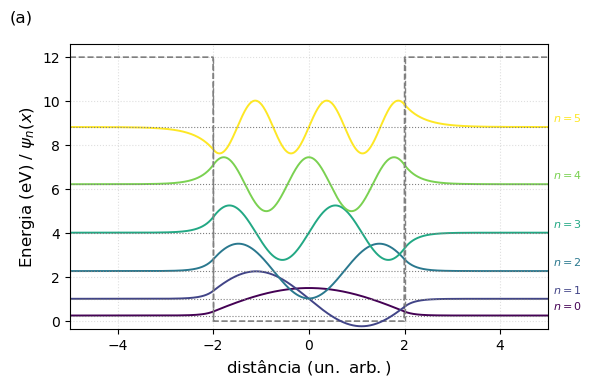

In [9]:
# Preparando para plot
V_plot = np.where((x < L_poco) & (x > -L_poco), 0.0, V0)
cores = plt.cm.viridis(np.linspace(0.15, 0.85, num_ligado))

# Construção gráfica das funções de onda
fig, ax = plt.subplots(figsize=(6,4))

# Colormap para diferenciar cada estado
cores = plt.cm.viridis(np.linspace(0, 1, len(E_ligado)))

# Desenhando o potencial
plt.plot(x, V_plot, color='tab:gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

# Plot das autofunções
for i, E in enumerate(E_ligado):
    """Encontra a amplitude máxima da curva"""
    #max_amp = np.max(np.abs(eigvecs_full[:, i])) 
    """Define um fator de escala (ajuste se necessário)"""
    fator_escala = 0.1 * V0 / max_amp
    plt.plot(x, E + fator_escala * autovetores_completo[:, i], color=cores[i], linewidth=1.4,
             label=rf"$n={i}$")
    plt.hlines(E, xmin, xmax, linestyle=':', color='gray', linewidth=0.8)

    plt.text(xmax + 0.1, E + 0.02 * V0, rf"$n={i}$", fontsize=8, color=cores[i])
# Adiciona a legenda (a) no canto superior esquerdo, em coordenadas do eixo
ax.text(-0.125, 1.12, '(a)', transform=ax.transAxes, fontsize=12,  va='top', ha='left')

plt.xlim(xmin, xmax)
plt.ylim(min(E_ligado) - 0.05*V0, 1.05*V0)

# Rótulos e legenda
plt.vlines([-L_poco, L_poco], 0, V0, color='gray', linestyle='--', linewidth=1.0)
plt.xlabel(r"distância $(\mathrm{un.\ arb.})$", fontsize=12)
plt.ylabel(r"Energia (eV) / $\psi_n(x)$", fontsize=12)

plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

### Construção gráfica apenas das densidades de probabilidade

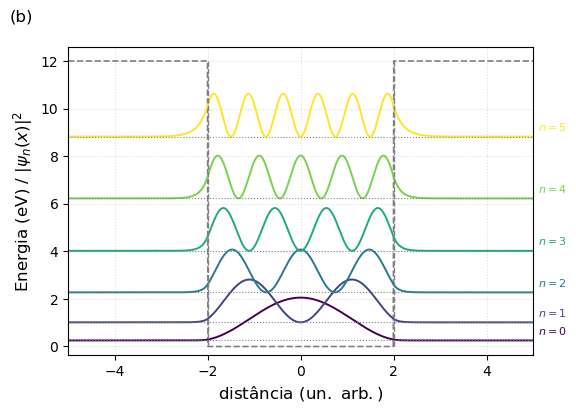

In [10]:
# Construção gráfica das densidades de probabilidade
fig, ax = plt.subplots(figsize=(6,4))

# Plot do potencial
plt.plot(x, V_plot, color='tab:gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

# Plot das densidades de probabilidade
for i, E in enumerate(E_ligado):
    # Encontra a amplitude máxima da curva
    max_amp = np.max(np.abs(autovetores_completo[:, i])**2) 
    # Define um fator de escala (ajuste se necessário)
    fator_escala_prob = 0.15 * V0 / max_amp
    plt.plot(x, E + fator_escala_prob * np.abs(autovetores_completo[:, i])**2, color=cores[i], linewidth=1.4,
             label=rf"$n={i}$")
    plt.hlines(E, xmin, xmax, linestyle=':', color='gray', linewidth=0.8)
    
    plt.text(xmax + 0.1, E + 0.02 * V0, rf"$n={i}$", fontsize=8, color=cores[i])
# Adiciona a legenda (b) no canto superior esquerdo, em coordenadas do eixo
ax.text(-0.125, 1.12, '(b)', transform=ax.transAxes, fontsize=12,  va='top', ha='left')
    
plt.xlim(xmin, xmax)
plt.ylim(min(E_ligado) - 0.05*V0, 1.05*V0)

# Rótulos e legenda
plt.vlines([-L_poco, L_poco], 0, V0, color='gray', linestyle='--', linewidth=1.0)
plt.xlabel(r"distância $(\mathrm{un.\ arb.})$", fontsize=12)
plt.ylabel(r"Energia (eV) / $|\psi_n(x)|^{2}$", fontsize=12)

plt.grid(True, linestyle=':', alpha=0.4)

plt.show()
plt.close()

## Oscilador Harmônico: Método de Numerov

In [11]:
### Funções auxiliares ###
def K(x, E):
    """k^2(x) para o oscilador harmônico (OH) adimensional."""
    return 2*E - x**2

def numerov(E, x):
    """Aplica o método de Numerov para o OH adimensional."""
    delta = x[1] - x[0]    # passo da malha espacial
    psi = np.zeros_like(x) # vetor para armazenar a solução
    
    # Condições iniciais
    psi[0] = 0.0
    psi[1] = delta
    
    # Recorrência de Numerov
    for i in range(2, len(x)):
        k0 = K(x[i-2], E)
        k1 = K(x[i-1], E)
        k2 = K(x[i], E)
        psi[i] = ((2 - 5*delta**2*k1/6)*psi[i-1] - (1 + delta**2*k0/12)*psi[i-2]) / (1 + delta**2*k2/12)
    return psi

def normalizacao(psi, x):
    """Normaliza a função de onda e garante fase positiva no pico."""
    norm = np.sqrt(np.trapz(np.abs(psi)**2, x))
    if norm > 0:
        psi = psi / norm
    # Ajuste de fase: garante que o maior pico seja positivo
    imax = np.argmax(np.abs(psi))
    if psi[imax] < 0:
        psi = -psi
    return psi

### Parâmetros do problema ###

# Domínio espacial: de -L até L
L = 6
N_pontos = 10000
x = np.linspace(-L, L, N_pontos)

E_min, E_max, dE = 0.4, 6.0, 0.01 # Intervalo de energias para busca dos autovalores
n_stados = 5 # Número de estados desejados

### Busca de autovalores ###
energia = []
list_psi = []

E_valores = np.arange(E_min, E_max, dE)
f_prev = numerov(E_valores[0], x)[-1]  # psi no último ponto

for E in E_valores[1:]:
    psi = numerov(E, x)
    f_curr = psi[-1]
    """
    Se há troca de sinal no valor da função de onda no contorno,
    então cruzamos um autovalor verdadeiro (condição de contorno satisfeita)
    """
    if f_prev * f_curr < 0:
        
        # Refina a energia encontrada usando bisseção
        a, b = E - dE, E
        for _ in range(20): # 20 iterações garantem boa precisão
            c = 0.5*(a + b)
            psi_c = numerov(c, x)
            if psi_c[-1] * numerov(a, x)[-1] < 0:
                b = c
            else:
                a = c
        E_star = 0.5*(a + b) # Autovalor refinado
        psi_star = normalizacao(numerov(E_star, x), x) # Autofunção correspondente, normalizada
        
        energia.append(E_star)
        list_psi.append(psi_star)

        # Interrompe quando já encontramos todos os estados desejados
        if len(energia) >= n_stados:
            break
    f_prev = f_curr

energia = np.array(energia)
array_psi = np.array(list_psi)

### Potencial do oscilador harmônico ###
def V(x):
    return 0.5*x**2


C:\Users\olive\AppData\Local\Temp\ipykernel_25988\3327920222.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(np.abs(psi)**2, x))


### Construção gráfica das funções de onda e densidade de probabilidade

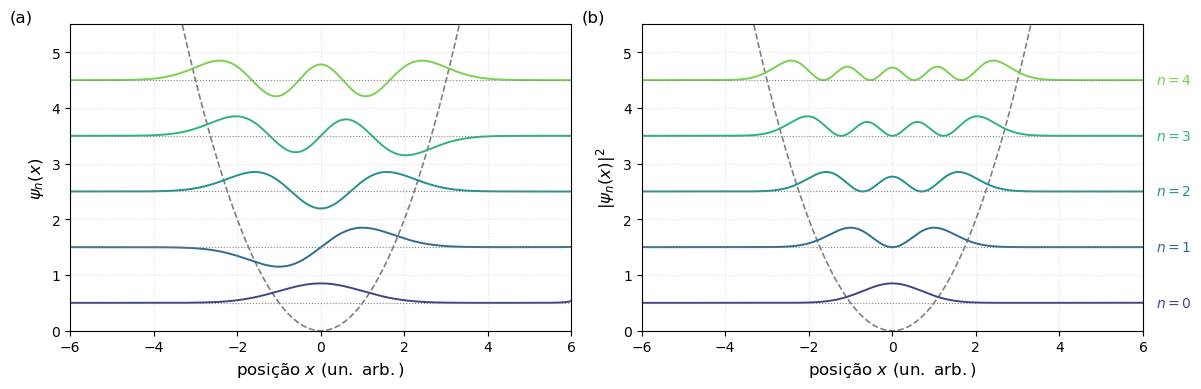

In [12]:
## Construção gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Colormap para diferenciar cada estado
cores = plt.cm.viridis(np.linspace(0.2, 0.8, len(energia)))

### Painel (a): Funções de onda ### 

# Desenhando o potencial
ax1.plot(x, V(x), color='tab:gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

for i, E_n in enumerate(energia):
    """Define um fator de escala (ajuste se necessário)"""
    escala = 0.35 / np.max(np.abs(array_psi[i]))
    
    ax1.plot(x, E_n + escala*array_psi[i], color=cores[i], linewidth=1.4,
             label=rf"$n={i}$, $E={E:.4f}$")
    ax1.hlines(E_n, x[0], x[-1], linestyle=':', color='gray', linewidth=0.8)

### Painel (b): Densidades de probabilidade ###

# Desenhando o potencial
ax2.plot(x, V(x), color='gray', linestyle='--', linewidth=1.2, label=r'$V(x)$')

for i, E_n in enumerate(energia):
    """Define um fator de escala (ajuste se necessário)"""
    escala_prob = 0.35 / np.max(abs(array_psi[i]**2))
    
    ax2.plot(x, E_n + escala_prob*array_psi[i]**2, color=cores[i], linewidth=1.4,
             label=rf"$n={i}$, $E={E:.4f}$")
    ax2.hlines(E_n, x[0], x[-1], linestyle=':', color='gray', linewidth=0.8)
    
    ax2.text(x[-1] + 0.3, E_n, f"$n={i}$", color=cores[i], fontsize=10, va='center')

### Ajustes finais ###
for ax, label in zip([ax1, ax2], ['(a)', '(b)']):
    ax.set_xlim(-L, L)
    ax.set_ylim(0, max(energia) + 1)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.text(-0.12, 1.05, label, transform=ax.transAxes, fontsize=12, va='top', ha='left')

ax1.set_xlabel(r"posição $x$ $(\mathrm{un.\ arb.})$", fontsize=12)
ax2.set_xlabel(r"posição $x$ $(\mathrm{un.\ arb.})$", fontsize=12)
ax1.set_ylabel(r"$\psi_n(x)$", fontsize=12)
ax2.set_ylabel(r"$|\psi_n(x)|^2$", fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
print("Energias encontradas (adimensionais):", energia)

Energias encontradas (adimensionais): [0.5 1.5 2.5 3.5 4.5]
